# Regression with FACET

***

**Robust and impactful Data Science with FACET**

FACET enables us to perform a number of critical steps in best practice Data Science work flow easily, efficiently and reproducibly:

1. Create a robust pipeline for learner selection using LearnerRanker and cross-validation.

2. Enhance our model inspection to understand drivers of predictions using local explanations of features via SHAP values by applying a novel methodology that decomposes SHAP values into measures of synergy, redundancy, and independence between each pair of features.

3. Quickly apply historical simulation to gain key insights into feature values that minimize or maximize the predicted outcome.

***

**Context**

The data are from simulated experiments of a naval vessel (Frigate) Gas Turbine (GT) propulsion plant. The simulator considers the performance decay over time of the GT components such as GT compressor and turbines. One observation in this dataset represents the current decay states of the compressor and the gas turbine along with several sensor readings of the vessel at that point in time. The decay state is a performance metric [0, 1] where 1 means delivering 100% of nominal performance. We want to determine the machine settings which maximize the gas turbine decay state coefficient.

Utilizing FACET we will: 

1. Predict the decay state of the gas turbine as accurately as possible
2. Understand which parameters drive the decay state of the turbine
3. Analyze how these drivers interact with each other and the target

While we can solve questions 1 and parts of question 2 with commonly used machine learning packages, `facet` will enable us to make better inferences about the way some of the features share or complement information and help us to figure out the optimal settings of the vessel to minimize the equipment degradation at a variety of ship speeds.

***

**Tutorial outline**

1. [Preprocessing and initial feature selection](#Preprocessing-and-initial-feature-selection)
2. [Selecting a learner using FACET ranker](#Selecting-a-learner-using-FACET-ranker)
3. [Using the FACET inspector for model inspection](#Using-the-FACET-inspector-for-model-inspection)
4. [FACET univariate simulator: the impact of waist to height ratio](#FACET-univariate-simulator:-the-impact-of-waist-to-height-ratio)
5. [Appendix](#Appendix)

In [1]:
# This cell is only required as long as the `facet` package is not public yet

# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

def _set_paths() -> None:
    # set the correct path when launched from within PyCharm

    module_paths = ["pytools", "facet", "sklearndf"]

    import sys
    import os
    
    if 'cwd' not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)   
    print(f"working dir is '{os.getcwd()}'")
    for module_path in module_paths:
        if module_path not in sys.path:
            sys.path.insert(0, os.path.abspath(f"{cwd}/{os.pardir}/{module_path}/src"))
        print(f"added `{sys.path[0]}` to python paths")
        
def _ignore_warnings():
    # ignore irrelevant warnings that would affect the output of this tutorial notebook
    
    # ignore a useless LGBM warning
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")

_set_paths()
_ignore_warnings()

del _set_paths, _ignore_warnings

working dir is '/mnt/c/projects/facet/facet'
added `/mnt/c/projects/facet/pytools/src` to python paths
added `/mnt/c/projects/facet/facet/src` to python paths
added `/mnt/c/projects/facet/sklearndf/src` to python paths


In [2]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

def _configure_matplotlib():
    # set global options for matplotlib
    
    import matplotlib
    
    matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)
    matplotlib.rcParams['figure.dpi'] = 72

_configure_matplotlib()

del _configure_matplotlib

# Required Imports

In order to run this notebook, we will import not only the `facet` package, but also a number of other packages useful to solve this task. Overall, we can break down the imports into three categories: 
1. Common packages (pandas, matplotlib, etc.)
2. Required `facet` classes (inpsection, selection, validation, simulation, etc.)
3. Other `gamma` packages which simplify pipelining with `sklearn` and provide some visualization utils

Conventional imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.model_selection import RepeatedKFold

Gamma Facet imports

In [4]:
from facet import Sample
from facet.crossfit import LearnerCrossfit
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.viz import SimulationDrawer

Sklearndf imports

Instead of using the "regular" scikit-learn package, we are using the `sklearndf` (see on [GitHub](https://github.com/orgs/BCG-Gamma/sklearndf/)) wrapper which keeps metadata such as column names when passing the data through the scikit-learn learners.  

In [5]:
# sklearndf
from sklearndf.pipeline import PipelineDF, RegressorPipelineDF
from sklearndf.regression import RandomForestRegressorDF
from sklearndf.regression.extra import LGBMRegressorDF
from sklearndf.transformation.extra import BorutaDF
from sklearndf.transformation import SimpleImputerDF

The sklearn.linear_model.stochastic_gradient module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.


In [6]:
from pytools.viz.dendrogram import DendrogramDrawer, DendrogramReportStyle
from pytools.viz.distribution import ECDFDrawer
from pytools.viz.matrix import MatrixDrawer

# Preprocessing and initial feature selection

First we need to load our turbine decay data and create a simple preprocessing pipeline. For those interested initial EDA can be found in the Appendix [Exploratory Data Analysis](#Exploratory-Data-Analysis)

In [7]:
# load the prepared dataframe
decay_df = pd.read_csv("sphinx/source/tutorial/gas_turbine_data.txt", delim_whitespace=True)

# assign human-readable labels
decay_df.columns = [
    'Lever Position',
    'Ship Speed', 
    'Turbine Shaft Torque (kN m)', 
    'Turbine Rate of Revolutions (rpm)', 
    'Generator Rate of Revolutions (rpm)', 
    'Starboard Propeller Torque (kN)', 
    'Port Propeller Torque (kN)', 
    'HP Turbine exit temp (C)', 
    'GT Compressor inlet air temp (C)', 
    'GT Compressor outlet air temp (C)', 
    'Turbine exit pressure (bar)', 
    'Compressor inlet air pressure (bar)', 
    'Compressor outlet air pressure (bar)', 
    'Turbine exhaust gas pressure (bar)', 
    'Turbine injection control', 
    'Fuel flow', 
    'GT Compressor decay state coeff',  
    'GT Turbine decay state coeff']

# need to drop the other target
decay_df.drop("GT Compressor decay state coeff", inplace=True, axis=1)

# have a look
decay_df.head()

,Lever Position,Ship Speed,Turbine Shaft Torque (kN m),Turbine Rate of Revolutions (rpm),Generator Rate of Revolutions (rpm),Starboard Propeller Torque (kN),Port Propeller Torque (kN),HP Turbine exit temp (C),GT Compressor inlet air temp (C),GT Compressor outlet air temp (C),Turbine exit pressure (bar),Compressor inlet air pressure (bar),Compressor outlet air pressure (bar),Turbine exhaust gas pressure (bar),Turbine injection control,Fuel flow,GT Turbine decay state coeff
0,2.088,6.0,6960.180,1376.166,6828.469,28.204,28.204,635.401,288.0,581.658,1.331,0.998,7.282,1.019,10.655,0.287,0.975
1,3.144,9.0,8379.229,1386.757,7111.811,60.358,60.358,606.002,288.0,587.587,1.389,0.998,7.574,1.020,13.086,0.259,0.975
2,4.161,12.0,14724.395,1547.465,7792.630,113.774,113.774,661.471,288.0,613.851,1.658,0.998,9.007,1.022,18.109,0.358,0.975
3,5.140,15.0,21636.432,1924.313,8494.777,175.306,175.306,731.494,288.0,645.642,2.078,0.998,11.197,1.026,26.373,0.522,0.975
4,6.175,18.0,29792.731,2307.404,8828.360,246.278,246.278,800.434,288.0,676.397,2.501,0.998,13.356,1.030,35.760,0.708,0.975


For easier management of the data we are using in this example, we are using FACET's `Sample` class, which allows to do a number of things: 

- Quickly access the target vs. features
- Pass the sample into `sklearndf` data pipelines
- Assign weight vectors to the sample which are propagated down to the learners (given that they support sample weighting)

In [8]:
TARGET = "GT Turbine decay state coeff"
sample = Sample(observations=decay_df, target=TARGET)

Next we should create a minimum preprocessing pipeline. However, based on our EDA ([Exploratory Data Analysis](#Exploratory-Data-Analysis-(EDA))) we have no missing values or a need to manage categorical variables etc. However, while it is not needed we will create a simple imputation preprocessing pipeline using [sklearndf's](https://github.com/BCG-Gamma/sklearndf) `SimpleImputerDF` to demonstrate how such a pipeline is created and included in subsequent analytic steps.

In [9]:
preprocessing_pipeline = PipelineDF(
    steps = [
        ("impute", SimpleImputerDF())
    ]
)

Next we perform some initial feature selection using the [Boruta](https://www.jstatsoft.org/article/view/v036i11) algorithm, a smart feature selection method to eliminate features whose predictive power is not better than random noise.

The BorutaDF transformer in our [sklearndf](https://github.com/BCG-Gamma/sklearndf) package provides easy access to this powerful method. The approach relies on a tree-based learner, usually a random forest.

For the random forest, we rely on default parameters but set the maximum tree depth to 5 (for Boruta, setting a depth between 3 and 7 is highly recommended and depends on the number of features and expected complexity of the feature/target interactions). The number of trees is automatically managed by the Boruta feature selector (argument n_estimators=”auto”).

We also use parallelization for the random forest using `n_jobs` to accelerate the Boruta iterations.

In [10]:
# create the Boruta object
boruta = BorutaDF(
    estimator = RandomForestRegressorDF(max_depth=5, random_state=42, n_jobs=3), 
    n_estimators="auto", 
    max_iter=50,
    random_state=42, 
    verbose=False
)

# combine Boruta with the preprocessing pipeline
selection_pipeline = PipelineDF(
    steps = [
        ("preprocess", preprocessing_pipeline),
        ("feature selection", boruta)
    ]
)

Since [sklearndf](https://github.com/BCG-Gamma/sklearndf) closely follows the `scikit-learn` syntax, we can fit this pipeline on the `sample.features` and `sample.target` properties.

In [11]:
# fit pipeline and print selected features
selection_pipeline.fit(X=sample.features, y=sample.target)
print(f"Selected features: {selection_pipeline.features_out.tolist()}")

Selected features: ['Turbine Shaft Torque (kN m)', 'Turbine Rate of Revolutions (rpm)', 'Generator Rate of Revolutions (rpm)', 'HP Turbine exit temp (C)', 'GT Compressor outlet air temp (C)', 'Compressor outlet air pressure (bar)', 'Turbine exhaust gas pressure (bar)', 'Turbine injection control', 'Fuel flow']


Boruta selected 9 features which we will now keep in our FACET sample object.

In [12]:
# update FACET sample object to only those features Boruta identified as useful
sample_selected = sample.keep(features=selection_pipeline.features_out)

# Selecting a learner using FACET ranker

`sklearndf` and `facet` implement a number of additional useful wrappers which further simplify comparing and tuning a larger number of models and configurations: 

- `LearnerGrid`: allows to pass a Regressor pipeline and a set of hyperparameters
- `LearnerRanker`: multiple LearnerGrids can be passed into the this class as a list - this allows tuning hyperparameters both across different types of learners in a single step and ranks the resulting models accordingly.

In [13]:
rf_pipeline = RegressorPipelineDF(
    regressor=RandomForestRegressorDF(random_state=42),
)

lgbm_pipeline = RegressorPipelineDF(
    regressor=LGBMRegressorDF(random_state=42),
)

For this problem, we want to tune two sets of hyperparameters for each learner and perform cross-validation. 

In [14]:
grid = [
    LearnerGrid(
        pipeline=rf_pipeline, 
        learner_parameters={ 
            "min_samples_leaf": [8, 16], 
            "n_estimators": [20, 50, 100]
        } 
        ),
    LearnerGrid(
        pipeline=lgbm_pipeline, 
        learner_parameters={ 
            "min_data_in_leaf": [8, 16], 
            "subsample": [0.8, 1], 
            "boosting_type": ["gbdt"]
        }
    )

]

We now fit the grid defined above using the `LeanerRanker`, which will run a gridsearch (or random search if defined) using 10 repeated 5-fold cross-validation on our selected set of features from Boruta.

In [15]:
ranker = LearnerRanker(
    grids=grid,
    cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
    n_jobs=-3
).fit(sample=sample_selected)

We can see how each model scored using the `summary_report()` method of the `LearnerRanker`.

In [16]:
# look at the top 5 models
print(ranker.summary_report(5))

Rank  1:         LGBMRegressorDF, ranking_score=    0.978, scores_mean=    0.981, scores_std=  0.00168, parameters={regressor__min_data_in_leaf=8,regressor__subsample=0.8,regressor__boosting_type=gbdt}

Rank  2:         LGBMRegressorDF, ranking_score=    0.978, scores_mean=    0.981, scores_std=  0.00168, parameters={regressor__min_data_in_leaf=8,regressor__subsample=1,regressor__boosting_type=gbdt}

Rank  3:         LGBMRegressorDF, ranking_score=    0.977, scores_mean=    0.981, scores_std=  0.00187, parameters={regressor__min_data_in_leaf=16,regressor__subsample=0.8,regressor__boosting_type=gbdt}

Rank  4:         LGBMRegressorDF, ranking_score=    0.977, scores_mean=    0.981, scores_std=  0.00187, parameters={regressor__min_data_in_leaf=16,regressor__subsample=1,regressor__boosting_type=gbdt}

Rank  5: RandomForestRegressorDF, ranking_score=    0.973, scores_mean=    0.978, scores_std=  0.00255, parameters={regressor__min_samples_leaf=8,regressor__n_estimators=100}



# Using the FACET inspector for model inspection

SHAP decomposition of features is a method we developed to identify pairs of features that share, or re-use information to predict the target. We distinguish two cases:

- **Synergy**: the degree to which two features jointly contribute to the prediction by combining information. For example, given features X and Y as coordinates on a chess board, the colour of a square can only be predicted when considering X and Y in combination


- **Redundancy**: the degree to which two features use the same information, independently of each other, to contribute to a prediction. For example, temperature and pressure in a pressure cooker are redundant features for predicting cooking time since pressure will rise relative to the temperature, and vice versa. Therefore knowing just one of either temperature or pressure will likely enable the same predictive accuracy.

Both cases can apply at the same time, i.e. a pair of features can use some information synergistically while using other information redundantly.

To analyse redundancy for all possible feature parings, the approach is:

1. Calculate the feature redundancy matrix using SHAP value decomposition - this gives us pairwise redundancy between features, in the range of 0.0 (fully unique contributions) and 1.0 (fully redundant contributions)

2. Transform the feature redundancy matrix into a feature distance matrix, where distance is expressed as (1.0 - redundancy)

3. Perform hierarchical, single-linkage clustering on the distance matrix, thus identifying groups of low-distance, redundant features which activate “in tandem” to predict the outcome

The same approach can be used to analyse synergy.

The inspector can calculate all of this with a single method call, but also offers methods to access the intermediate results of each step. A lightweight visualization framework is available to render the results in different styles.

In [17]:
inspector = LearnerInspector()
inspector.fit(crossfit=ranker.best_model_crossfit)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


## Synergy and redundancy

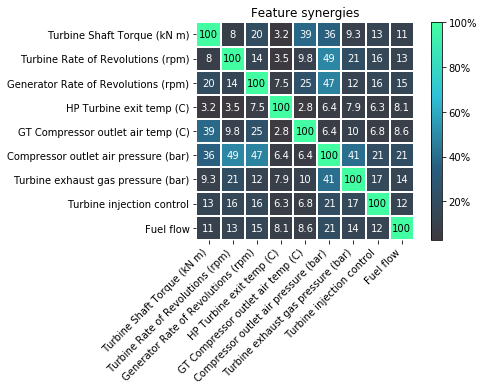

In [18]:
# synergy heatmaps
synergy_matrix = inspector.feature_synergy_matrix()
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Feature synergies")

We can see in the synergy matrix that the feature "Compressor outlet air pressure (bar)" is highly synergystic with other features. This means that the outlet air pressure **in combination** with the turbine torque, rate of revolutions and generator rate of revolutions carries a lot of information for the model. It should not be surprising that this feature also as the highest mean absolute SHAP score. 

We can see that this uncovers very high redundancy which would not have been visible in a simple correlation matrix.

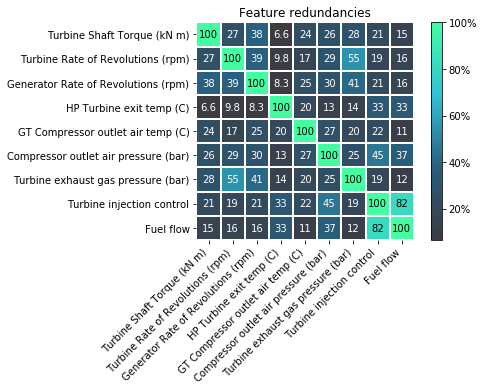

In [19]:
# redundancy heatmap
redundancy_matrix = inspector.feature_redundancy_matrix()
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Feature redundancies")

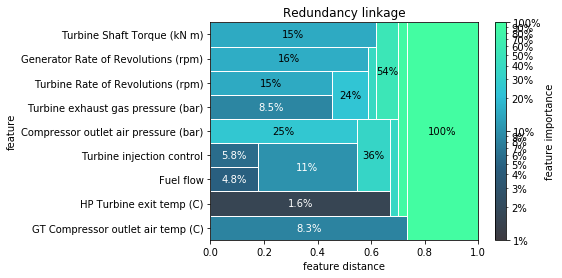

In [20]:
# redundancy dendrogram
redundancy = inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(title="Redundancy linkage", data=redundancy)

For convenience when working in a non-notebook environment, all of the `Drawer`s provided by the [pytools](https://github.com/BCG-Gamma/pytools) package also support a `style='text'` flag.  

In [21]:
DendrogramDrawer(style="text").draw(title="Redundancy linkage", data=redundancy)

****************************** Redundancy linkage ******************************
                                                                                
Turbine Shaft T 15% -------------------------------------\                      
Generator Rate  16% -----------------------------------\ |____                  
Turbine Rate of 15% ---------------------------\_______/-/    \                 
Turbine exhaust  9% ---------------------------/              |                 
Compressor outl 25% --------------------------------\         |\--------------- 
Turbine injecti  6% ----------\_____________________/-------\_/|                
Fuel flow        5% ----------/                             |  |                
HP Turbine exit  2% ----------------------------------------/  |                
GT Compressor o  8% -------------------------------------------/                


In [22]:
redundant_features = ["Fuel flow", "Turbine exhaust gas pressure (bar)"]

To obtain the hierarchical clustering, we calculate a linkage tree and plug it into a dendrogram drawer. This makes it easy to visually single out features that are both important and mutually redundant.

### What can we learn from the above? 


**Synergy**
We can see in the synergy matrix that the feature "Compressor outlet air pressure (bar)" is highly synergystic with other features. This means that the outlet air pressure **in combination** with the turbine torque, rate of revolutions and generator rate of revolutions carries a lot of information for the model. It should not be surprising that this feature also as the highest mean absolute SHAP score. 

When simulating the data, we should look at these features first in order to figure out which feature maximized the decay state coefficient. 

**Redundancy**
The redundancy matrix and dendrogram reveals a "cluster" of two variables which are highly redundant - Turbine injection control and Fuel flow. That is, they provide the same information to the target and are likely dependent on each other. Looking at the process, the fuel flow is a consequence from the turbine injection control, so we can remove this redundant feature. 

It is important to remove redundant features before running the simulation. As we simulate single features along their historical partition while keeping all other observations the same, we risk creating adversing signals when the model makes a prediction about the target if we simulate one feature, but don't change the feature it shares information with alongside. 




In turn, we remove the redundant features from the sample and create a revised sample on which we re-train the pipeline.

In [23]:
sample_revised = sample_selected.drop(redundant_features)

In [24]:
# Run the training pipeline again
ranker_revised = LearnerRanker( 
    grids=grid,
    cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
    n_jobs=-3
).fit(sample=sample_revised)

In [25]:
ranker_revised.best_model

RegressorPipelineDF(regressor=LGBMRegressorDF(min_data_in_leaf=8,
                                              random_state=42, subsample=0.8))

# FACET univariate simulator: the impact of compressor outlet air temp

Another advantage of FACET is the ability to quickly instigate and run univariate simulation. From the synergy matrix, we can see that the Compressor outlet temperature has the highest synergy with most other features. Therefore, we want to see how the target behaves if we simulate this feature such that each state had a constant outlet compressor temperature.

The absolute SHAP values also confirm that the three features most synergistic with `GT Compressor outlet air temp (C)` are also the most important features according to the model:

In [26]:
abs_shap_values = inspector.shap_values().abs().sum(axis=0).reset_index().rename({0: "Sum of abs SHAP values"}, axis=1)
abs_shap_values.sort_values(by="Sum of abs SHAP values", ascending=False)

,feature,Sum of abs SHAP values
5,Compressor outlet air pressure (bar),49.276607
1,Turbine Rate of Revolutions (rpm),28.983599
2,Generator Rate of Revolutions (rpm),24.668069
0,Turbine Shaft Torque (kN m),19.832159
6,Turbine exhaust gas pressure (bar),14.490199
4,GT Compressor outlet air temp (C),11.485023
7,Turbine injection control,10.396192
8,Fuel flow,8.215846
3,HP Turbine exit temp (C),3.114945


As the basis for the simulation, we divide the feature into relevant partitions: 

- We use the `facet.simulation.partition.ContinuousRangePartitioner` to split the range of observed values of the outlet air temperature into intervals of equal size. Each partition is represented by the central value of that partition. 
- For each partition, the simulator creates an artificial copy of the original sample assuming the variable to be simulated has the same value across all observations - which is the value representing the partition. Using the best LearnerCrossfit acquired from the ranker, the simulator now re-predicts all targets using the models trained for all folds, and determines the average uplift of the target variable resulting from this.
- The `facet.simulation.viz.SimulationDrawer` visualized the result; both in a matplotlib and a plain-text style

Finally, because FACET can use bootstrap cross validation, we can create a crossfit from our previous LearnerRanker best model to perform the simulation so we can quantify the uncertainty by using bootstrap confidence intervals.

In [27]:
boot_crossfit = LearnerCrossfit(
    pipeline=ranker_revised.best_model.native_estimator,
    cv=BootstrapCV(n_splits=250, random_state=42),
    n_jobs=-3,
    verbose=2
).fit(sample=sample_revised)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  29 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-3)]: Done 150 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-3)]: Done 250 out of 250 | elapsed:   23.0s finished


In [28]:
# set-up and run a simulation
SIM_FEATURE = 'GT Compressor outlet air temp (C)'
simulator = UnivariateUpliftSimulator(crossfit=boot_crossfit, n_jobs=3)
partitioner = ContinuousRangePartitioner()
univariate_simulation = simulator.simulate_feature(name=SIM_FEATURE, partitioner=partitioner)

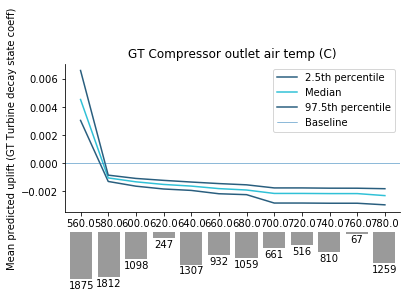

In [29]:
# visualize the results
SimulationDrawer().draw(data=univariate_simulation, title=SIM_FEATURE)

In [30]:
# can also get a print out of simulation results
SimulationDrawer("text").draw(data=univariate_simulation, title=SIM_FEATURE)

GT Compressor outlet air temp (C)

Mean predicted uplift (GT Turbine decay state coeff):

Baseline = 0.0

Partition  2.5th percentile  Median     97.5th percentile
=========  ================  =========  =================
560                0.00303    0.00452            0.00659 
580               -0.00133   -0.00108           -0.000877
600               -0.00166   -0.00135           -0.00111 
620               -0.00187   -0.00154           -0.00125 
640               -0.00197   -0.00166           -0.00137 
660               -0.00221   -0.00184           -0.00148 
680               -0.00227   -0.00194           -0.00157 
700               -0.00287   -0.00218           -0.00179 
720               -0.00287   -0.00218           -0.00179 
740               -0.00288   -0.00219           -0.00181 
760               -0.00288   -0.00219           -0.00181 
780               -0.003     -0.00234           -0.00185 

Observed frequencies:

Partition  Frequency
=========  =========
560             

We can see from this that the turbine decay state coefficient is maximized when the outlet air temperature of the gas turbine is as small as possible. Note that this is only looking at the partitions of the historically observed range, as extrapolating these predictions into unobserved regions would risk creating infeasible scenarios. 

# Appendix

## Data source

**Dataset**

The dataset used in this example is available on [Kaggle](https://www.kaggle.com/elikplim/maintenance-of-naval-propulsion-plants-data-set) and contains data from experiments carried out by means of a numerical simulator of a naval vessel (Frigate) characterized by a **Gas Turbine propulsion plant**. In this release of the simulator it is also possible to take into account the performance decay over time of the GT components such as GT compressor and turbines.

Each possible degradation state of the plant can be characterized by three parameters: 

- Ship speed (linear function of the lever position)
- Compressor degradation coefficient kMc
- Turbine degradation coefficient

The degradation coefficients typically vary between [1; 0.95] for compressor and [1; 0.975] for the gas turbine. 

**Features**

One observation in this dataset represents the current decay states of the compresor and the gas turbine along with a number of sensor readings of the shipping vessels at that point in time. 

Our target, the Gas Turbine decay  state is being modelled as a performance decay state metric which is measured as 1 to 0, 1 meaning delivering 100% of the nominal performance. Therefore, we want to determine the machine settings which **maximize the gas turbine decay state coefficient**. 


**Learning Problem**

For this learning problem, we have three key objectives: 

1. Predict the decay state of the gas turbine as accurately as possible
2. Understand which parameters drive the decay state of the turbine
3. Analyze how these drivers interact with each other and the target


While we can solve questions 1 and parts of question 2 with commonly used machine learning packages, `facet` will enable us to make better inferences about the way some of the features share or complement information and help us to figure out the optimal settings of the vessel to minimize the equipment degradation at a variety of ship speeds.

Reference for the dataset used in this example is: A. Coraddu, L. Oneto, A. Ghio, S. Savio, D. Anguita, M. Figari, Machine Learning Approaches for Improving Condition?Based Maintenance of Naval Propulsion Plants, Journal of Engineering for the Maritime Environment, 2014, DOI: 10.1177/1475090214540874, (In Press)

## Exploratory Data Analysis (EDA)

In [31]:
df = pd.read_csv("sphinx/source/tutorial/gas_turbine_data.txt", delim_whitespace=True)

df.columns = ['Lever Position', 
              'Ship Speed', 
              'Turbine Shaft Torque (kN m)', 
              'Turbine Rate of Revolutions (rpm)', 
              'Generator Rate of Revolutions (rpm)', 
              'Starboard Propeller Torque (kN)', 
              'Port Propeller Torque (kN)', 
              'HP Turbine exit temp (C)', 
              'GT Compressor inlet air temp (C)', 
              'GT Compressor outlet air temp (C)', 
              'Turbine exit pressure (bar)', 
              'Compressor inlet air pressure (bar)', 
              'Compressor outlet air pressure (bar)', 
              'Turbine exhaust gas pressure (bar)', 
              'Turbine injection control', 
              'Fuel flow', 
              'GT Compressor decay state coeff',  
              'GT Turbine decay state coeff']

TARGET = "GT Turbine decay state coeff"

In [32]:
# need to drop the other target
df.drop("GT Compressor decay state coeff", inplace=True, axis=1)
sample = Sample(observations=df, target=TARGET)

In [33]:
# Describe the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Lever Position,11933.0,5.167004,2.626239e+00,1.138,3.144,5.140,7.148,9.300
Ship Speed,11933.0,15.001006,7.745837e+00,3.000,9.000,15.000,21.000,27.000
Turbine Shaft Torque (kN m),11933.0,27249.757760,2.214817e+04,253.547,8375.886,21630.666,39001.427,72784.872
Turbine Rate of Revolutions (rpm),11933.0,2136.355191,7.740828e+02,1307.675,1386.758,1924.326,2678.079,3560.741
Generator Rate of Revolutions (rpm),11933.0,8201.074989,1.091272e+03,6589.002,7058.402,8482.088,9132.610,9797.103
Starboard Propeller Torque (kN),11933.0,227.354184,2.004942e+02,5.304,60.317,175.268,332.365,645.249
Port Propeller Torque (kN),11933.0,227.354184,2.004942e+02,5.304,60.317,175.268,332.365,645.249
HP Turbine exit temp (C),11933.0,735.518197,1.736700e+02,442.364,589.875,706.048,834.091,1115.797
GT Compressor inlet air temp (C),11933.0,288.000000,0.000000e+00,288.000,288.000,288.000,288.000,288.000
GT Compressor outlet air temp (C),11933.0,646.223347,7.267365e+01,540.442,578.102,637.142,693.928,789.094


We can also quickly check for missing values, although we can see that there appears to be none.

In [34]:
# count missing by feature
df.isna().sum(axis=0)

Lever Position                          0
Ship Speed                              0
Turbine Shaft Torque (kN m)             0
Turbine Rate of Revolutions (rpm)       0
Generator Rate of Revolutions (rpm)     0
Starboard Propeller Torque (kN)         0
Port Propeller Torque (kN)              0
HP Turbine exit temp (C)                0
GT Compressor inlet air temp (C)        0
GT Compressor outlet air temp (C)       0
Turbine exit pressure (bar)             0
Compressor inlet air pressure (bar)     0
Compressor outlet air pressure (bar)    0
Turbine exhaust gas pressure (bar)      0
Turbine injection control               0
Fuel flow                               0
GT Turbine decay state coeff            0
dtype: int64

We can use pytool's `ECDFDrawer()` to draw the cumulative distribution of the target. This shows us that the target is uniformly distributed in increments of 0.001 increments.

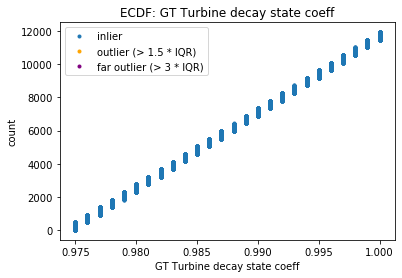

In [35]:
# look at the target distribution
ECDFDrawer().draw(sample.target)

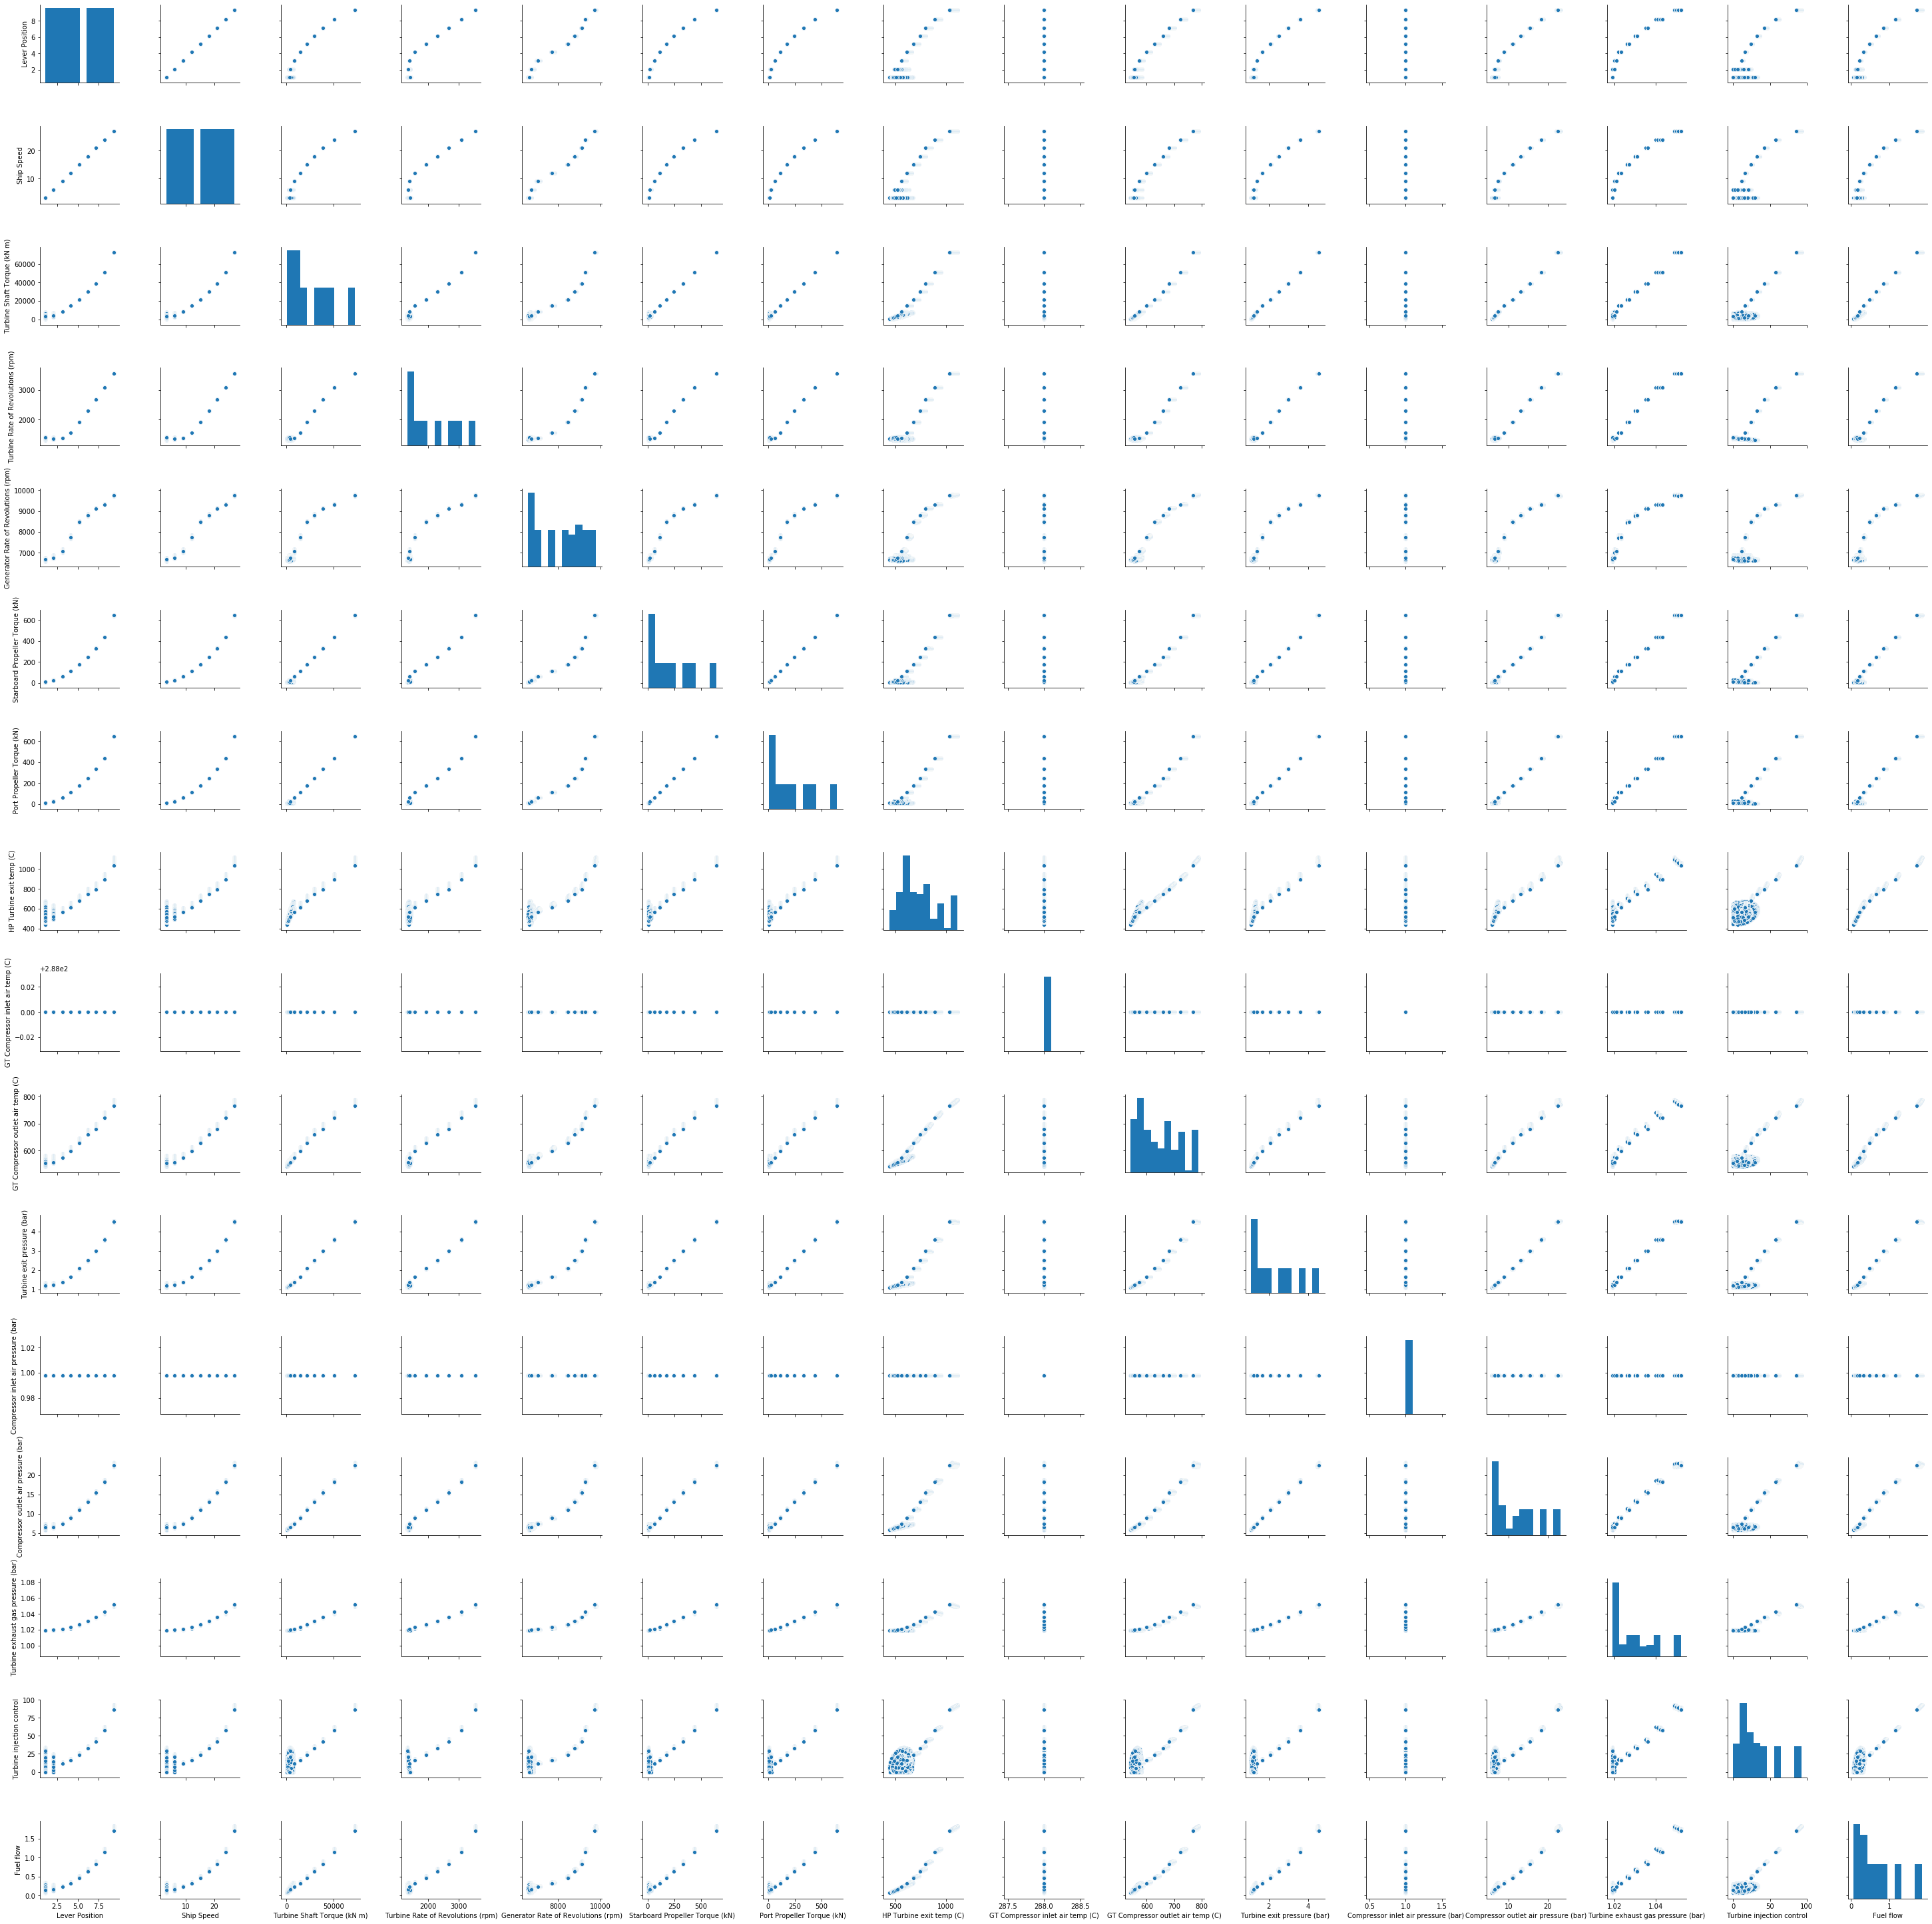

In [36]:
# look at feature distributions and correlations
sns.pairplot(sample.features)

**Quick EDA summary:**

- We have no missing values in our data
- We are dealing with a linearly distributed target
- The features exhibit a mixture of linear and non-linear relationships amongst each other. This gives us reason to test a number of non-parametric models and compare their performance. 
- Some features appear to be constant and should therefore be filtered out